# Background

+ Multiple importance sampling (MIS)

The key idea of MIS reweighting is to construct a mixture distribution to describe all biased samples
chosen, and then we can unbiased these biased samples using an importance sampling technique [1].

$P_{mix}(x) = \frac{1}{N_{tot}}\sum_{k=1}^K{n_k * P_k(x)}$

$= \frac{1}{N}\sum_{k=1}^K{n_k * e^{f_k - u_k(x)}}$, (1)

where $u_k(x) = \beta_k E_k(x)$ is the reduced potential and $P_{mix}(x)$ is a mixture distribution to describe all chosen biased samples. $n_k$ is the number of $k^{th}$ biased samples and $k$ ranges from $1$ to $K$ bias simulations, $N = \sum_{k}{n_k}$.

To understand the insight behind, we probably look at them from a probability expansion,

$P(A) = \sum_i P(B_i) P(A|B_i)$,

where $P(A|B_i)$ is essentially the number of samples for each bias simulation.

Any observation can be calculated using the following equation,

$<A> = \int{A(x)P(x)}dx = \int{A(x)\frac{P(x)}{P_{mix}(x)} P_{mix}(x)}dx$

$= \sum_{n=1}^{N} A(x_n) w(x_n), x_n \in P_{mix}(x)$, (2)

where $ w(x_n) = \frac{1}{N} \sum_{n=1}^{N} \frac{P(x_n)}{P_{mix}(x_n)} $ and it subjects to $\sum_{n} w(x_n) = 1$.

+ Free energies ($f_k$) calculated from the Multistate Bennett Acceptance Ratio (MBAR) equation

$\int{P_k(x)dx} = \frac{1}{N}\sum_n\frac{P_k(x_n)}{P_{mix}(x_n)} = \sum_n\frac{e^{f_k - u_k(x_n)}}{\sum_{k=1}^K{n_k * e^{f_k - u_k(x_n)}}} = 1$, (3)

then, the free energies ($f_k$) can be iteratively solved by a self-consistent iteration, given a set of initial guess [2]. A good guess of each free energy could be the average of its reduced potential.
It is noted that the different set of chosen samples (such as choosing the different $n_k$ values)
could have an effect on estimating the free energies, which probably gives us different results.


**Reference**

[1]. Shirts, Reweighting from the mixture distribution as a better way to describe the Multistate Bennett Acceptance Ratio, arXiv:1704.00891

[2]. Shirts and Chodera, Statistically optimal analysis of samples from multiple equilibrium states, J. Chem. Phys. 129, 124105 (2008)

# General implementation

+ Calculating the reduced potentials for all biased samples, $u_k(x_n)$

    Using the equation, $u_k(x_n) = \beta E_k(x_n)$, to obtain the array $u_k(x_n)$, and 
$k$ loops over all biased simulations and $x_n$ loops over all biased samples.

+ Obtaining a set of biased samples and and counting the number of samples of each bias simulation ($n_k$)

+ Obtaining the free energies ($f_k$) by using MBAR iterations (Eq. 3)

+ Evaluating the observations using Eq. 2


# Example. CA-CA model

The simplest example is the di-atom model (CA - CA).
Initially, we need to run the umbrella sampling that has six bias simulations simulations with different bias harmonic potentials.

## Import python packages

In [1]:
import glob # used for processing multiple files
import numpy as np
from matplotlib import pyplot as plt
from pymbar import MBAR # please see 4.1 for installation
from scipy import special

## Going to the working folder and run the umbrella simulations

In [2]:
wdir = '/home/ping/tutorial/mbar/'
%cd $wdir
%ls -lt


/home/ping/tutorial/mbar
total 3112
-rw-r--r-- 1 ping jianhanc  53853 Sep  2 16:39 mbar.ipynb
-rw-r--r-- 1 ping jianhanc    224 Oct  1  2021 README
-rw-r--r-- 1 ping jianhanc 344913 Oct  1  2021 mbar.html
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d9k2t300.dat
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d8k2t300.dat
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d7k2t300.dat
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d6k2t300.dat
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d5k2t300.dat
-rw-r--r-- 1 ping jianhanc 460048 Sep 29  2021 d4k2t300.dat


**Notes**

There are six data files that include the "time, distance, energy" of each simulation. For example, "d4k2t300.dat' means that the distance of CA-CA system was constrained in around 4 Angstrams, k force constant is 2, and temperature is 300 K.

In fact, we only need the trajectories (or distances) of all simulations, and then count the $n_k$ and calculate the unitless reduced potential $u_k(x_n)$.

## Obtain the trajectories of all simulations

>> Extract trajectories (xn) for each biased simulations 
file 0 >  /home/ping/tutorial/mbar/d4k2t300.dat
file 1 >  /home/ping/tutorial/mbar/d5k2t300.dat
file 2 >  /home/ping/tutorial/mbar/d6k2t300.dat
file 3 >  /home/ping/tutorial/mbar/d7k2t300.dat
file 4 >  /home/ping/tutorial/mbar/d8k2t300.dat
file 5 >  /home/ping/tutorial/mbar/d9k2t300.dat
traj.shape =  (60000,)


Text(0, 0.5, 'CA-CA distances ($\\AA$)')

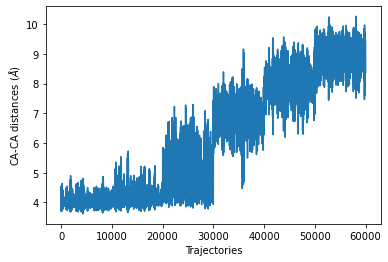

In [3]:
info = '>> Extract trajectories (xn) for each biased simulations '
print(info)
# six windows
# d4k2t300.dat; R = 4
# d5k2t300.dat; R = 5
# d6k2t300.dat; R = 6
# d7k2t300.dat; R = 7
# d8k2t300.dat; R = 8
# d9k2t300.dat; R = 9
datafiles = glob.glob(wdir+'*.dat')
datafiles = sorted(datafiles)
for k in range(0,len(datafiles)):
    print('file '+str(k)+' > ', datafiles[k])
traj = [np.loadtxt(f) for f in datafiles]
traj = np.concatenate(traj)[:,1] # extracting the distance
print('traj.shape = ', traj.shape)
plt.plot(traj)
plt.xlabel('Trajectories')
plt.ylabel(r'CA-CA distances ($\AA$)')

## Calculating relative free energies (fk) using MBAR

In [4]:
# calculating unitless reduced potential, uk(xn)
# Here, we wrote a python script to obtain the energies of systems, due to this is a simple system.
# We often calcualte them by a three-party program you used to do the umbrella sampling simulation.
# -------------

# parameters
kcons = 2
T = 300
beta = 1/0.593*298/T
R_arr = np.arange(4,10)
lenR = len(R_arr)
ntraj = len(traj)

# ULJ(r) = epsilon * ((Rmin/r)**12 - 2*(Rmin/r)**6)
def ULJ(r):
    eps1 = -5.0 # CA-1 carbon
    halfRmin1 = 2.000000
    eps2 = -5.0 # CA-2 carbon
    halfRmin2 = 2.000000
    epsilon = np.sqrt(eps1 * eps2)
    Rmin = halfRmin1 + halfRmin2
    epsilon = np.sqrt(eps1 * eps2)
    Rmin = halfRmin1 + halfRmin2
    return epsilon * ((Rmin/r)**12 - 2*(Rmin/r)**6)

# calculating unitless reduced potential
info = '>> Calculate biased reduced potentials (ukln = uk(xln)), xln -> xn'
print(info)
ukn = np.zeros((lenR, ntraj)) # biased reduced potentials without the unbiased term
for k in range(0,lenR):
    ukn[k,:] = beta * (ULJ(traj) + kcons/2*(traj-R_arr[k])**2)
print('ukn.shape = ', ukn.shape)
print('\n')

# Counting the number of samples of each simulation (nk)
# ------------
# each simulation has 10000 trajecties, 
# but it is unnecessary to choose all samples, and 
# choosing the optimal nk is an open question.
info = '>> Calculate nk of each simulation'
print(info)
nk = [10000, 10000, 10000, 10000, 10000, 10000]
print('nk = ', nk)
print('np.sum(nk) = ', np.sum(nk))
print('\n')

# Obtaining the relative free energies (𝑓𝑘) by using MBAR iterations
# -----------
info = '>> Calcualte relative free energies for each biased simulation (fk)'
print(info)
mbar = MBAR(ukn, nk)
fk = mbar.f_k
print('fk = ', fk)


>> Calculate biased reduced potentials (ukln = uk(xln)), xln -> xn
ukn.shape =  (6, 60000)


>> Calculate nk of each simulation
nk =  [10000, 10000, 10000, 10000, 10000, 10000]
np.sum(nk) =  60000


>> Calcualte relative free energies for each biased simulation (fk)
fk =  [0.         1.11936788 4.19752867 5.54399763 5.73807439 5.86545308]


## Constructing a mixture probability distribution

$P_{mix}(x) = \sum_{k=1}^K{c_k * e^{f_k - \beta_kE_k(x)}}$,

$c_k = \frac{n_k}{\sum_k{n_k}}$,

where $f_k$ is the relative free energies, this mixture probability can be used to describe the chosen samples.
In this way, given all samples, we should know how to calcualte this mixture probability, and 
all properties can be calculated from this mixture probability.

## Property analysis: distance of CA-CA

+ Theory

$Prob(R) = \frac{\int{\delta(r-R)P(x)dx}}{\int{P(x)dx}} = C\int{\delta(r-R)P(x)dx}$

$= C * 4\pi\int{\delta(r-R)P(r)r^2dr} = 4\pi R^2P(R)$,

+ MBAR analysis

$Prob(R) = \frac{\int{\delta(r-R)P(x)dx}}{\int{P(x)dx}} = C\int{\delta(r-R)P(x)dx}$

$= C * \frac{1}{N}\sum_{n=1}^{N}\delta(r_n-R)\frac{P(x_n)}{P_{mix}(x_n)}$,

+ Free energy (kT)

$PMF(R) = -log(Prob(R))$.

In [5]:
# MBAR
bins = np.arange(3.6, 10, 0.1)
logweights = -beta*ULJ(traj) - special.logsumexp(fk-ukn.T, b=nk, axis=1)
hist,bins = np.histogram(traj, bins=bins, weights=np.exp(logweights), density=True)
dist = (bins[0:-1] + bins[1:])/2
pmf_mbar = -np.log(hist)

# theory
pr = dist*dist*np.exp(-beta*ULJ(dist)) 
pr = 10 * pr/pr.sum() # probability, normalized
pmf_theory = -np.log(pr) # reduced free energy G(r) = -log(P(r))

## Plotting: MBAR vs. theory

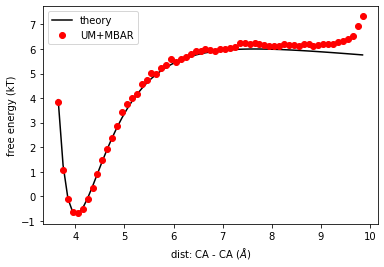

In [6]:
# plot the PMF (Umbrella sampling + MBAR ~ theory)
# ------------
plt.plot(dist, pmf_theory,'k-', dist, pmf_mbar,'ro')
plt.xlabel('dist: CA - CA ($\AA$)')
plt.ylabel('free energy (kT)')
plt.legend(('theory', 'UM+MBAR'))


# Appendix 

## How to calculate relative free energies: pymbar and FastMBAR

There are two packages to cacluate the relative free energies ($f_k$), including the pymbar and FastMBAR, where the FastMBAR has been optimized in both CPU and GPU calculations. Please look at the following references for details.

Another option is to use the following function to calcualte them iteratively,

$f_k^{(iter+1)} = -log(\sum_n{\frac{e^{-u_k(x_n)}}{\sum_k{n_k e^{f_k^{iter} - u_k(x_n)}}}})$.


In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import special

# define functions
# compute_fk using the ukn and nk.
# -----------
def compute_fk(ukn, nk, tol=1e-07, prnlev=0):
    r"""calculating the relative free energies (f_k)."""

    fk = np.zeros(len(nk))
    nsamples = ukn.shape[1]

    # requirement: N == np.sum(nk)
    if np.sum(nk) != nsamples:
        print('np.sum(nk), nsamples = ', np.sum(nk), nsamples)
        raise ValueError(
            '''the sum of nk has to be the same 
               as the number of trajectory frames.'''
        )

    # calcualting fk iteratively
    kstep = 0
    err_max = 999
    while err_max >= tol:
        fk_new = -special.logsumexp(-ukn-special.logsumexp(fk-ukn.T, b=nk, axis=1), axis=1)
        fk_new = fk_new - fk_new[0]
        err_max = np.max(np.abs(fk_new - fk))
        fk = fk_new
        kstep += 1
        if prnlev: print('kstep, err_max = ', kstep, err_max)

    return fk

**Reference**

[1]. pymbar installation: https://github.com/choderalab/pymbar

[2]. FastMBAR installation: https://github.com/xqding/FastMBAR

## Estimating relative free energies from other approach

$e^{-f_k} = \int{e^{-u_k(x)}dx}$,

this integral can be also approximated using a cumulant expansion,

$f_k = -log(<e^{-u_k(x)}>) = {\sum_k{\frac{C_{k}}{k!} }}$,

$C_1 = <u_k(x)>$,

$C_2 = <u_k(x)^2> - <u_k(x)>^2$.


**Reference**

[1]. Miao et al., Gaussian Accelerated Molecular Dyanmics: Unconstrained Enhanced Sampling and Free Energy Calculation, J. Chem. Theory Comput. 2015, 11, 3584-3595


## How to choose the samples from each bias simulation

We can choose all samples, which however could be not the optimal choose, because they could be highly correlated.

The pymbar package provided a timeseries module to extract these independent samples, please refer to [this link](https://pymbar.readthedocs.io/en/master/timeseries.html). 

## Questions

1) If each bias simulation collects different samples, then how can we use the MBAR to combine these samples?

hint: the collected samples are supposed to be independent

2) Can this MBAR reweighting be used for any biasing simulations? For example, the free energy perburbation, metadynamics, replica exchange simulations, etc.

hint: please check out the background part.

3) The most expensive part usually is the calculations of reduced potentials, then is there any a fast way to minimize these calculations?

hint: please refer to the Eq. (3) in the background.